# Fine-Tuning Phi-4 for Text Classification

This notebook fine-tunes the Phi-4 model for text classification using the `stanfordnlp/sst2` dataset. It includes dataset downloading, preprocessing, fine-tuning with LoRA and Unsloth, and evaluation with Accuracy and training loss plotting.

## Setup
- **Environment**: Google Colab with T4 GPU (16GB VRAM).
- **Libraries**: Unsloth for efficient fine-tuning, Hugging Face Transformers, Datasets, and Evaluate for metrics.
- **Dataset**: `stanfordnlp/sst2`.
- **Output**: Fine-tuned model, Accuracy plotting, and loss graph.




In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

## 1. Load Model and tokennizer
Load the Phi-4 model with 4-bit quantization using Unsloth for memory efficiency.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-4",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/160k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.39G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/170 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.15M [00:00<?, ?B/s]

## 2. Configure Model with LoRA adapter

Use LoRA for parameter-efficient fine-tuning.



In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None,
)

Unsloth 2025.5.9 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


## 3. Load and Preprocess Dataset

We load the `standfordnlp/sst2` dataset and preprocess it to extract classification tasks.




In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-4",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

from datasets import load_dataset

sst2_dataset = load_dataset('glue', 'sst2')

def format_sst2_for_chat(examples):
    texts = []
    for sentence, label in zip(examples['sentence'], examples['label']):
        sentiment = "positive" if label == 1 else "negative"

        conversation = [
            {"from": "human", "value": f"Analyze the sentiment of this sentence: {sentence}"},
            {"from": "gpt", "value": sentiment}
        ]

        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        texts.append(text)

    return {"text": texts}

total_size = len(sst2_dataset['train'])
sample_size = int(0.01 * total_size)
subset_dataset = sst2_dataset['train'].select(range(sample_size))

formatted_dataset = subset_dataset.map(format_sst2_for_chat, batched=True)

print("Formatted sample:")
print(formatted_dataset[0]['text'])
print("\n" + "="*50 + "\n")
print(formatted_dataset[1]['text'])

train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTotal original dataset size: {total_size}")
print(f"Using 1% subset size: {sample_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/673 [00:00<?, ? examples/s]

Formatted sample:
<|im_start|>user<|im_sep|>Analyze the sentiment of this sentence: hide new secretions from the parental units <|im_end|><|im_start|>assistant<|im_sep|>negative<|im_end|>


<|im_start|>user<|im_sep|>Analyze the sentiment of this sentence: contains no wit , only labored gags <|im_end|><|im_start|>assistant<|im_sep|>negative<|im_end|>

Total original dataset size: 67349
Using 1% subset size: 673
Train dataset size: 605
Validation dataset size: 68


## 4. Setting Up Training Arguments and Fine-tune Model

Use SFTTrainer with Unsloth to fine-tune the model.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        warmup_steps = 2,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = [],
    ),
)

print("Set up trainer successful!")
print(f"training {50} steps with batch size {4}")

Unsloth: Tokenizing ["text"]:   0%|          | 0/605 [00:00<?, ? examples/s]

Set up trainer successful!
training 50 steps with batch size 4


In [ ]:
print("=== START TRAINING ===")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 4")
print(f"Total steps: 50")
print("=" * 50)

trainer_stats = trainer.train()

print("\n=== END TRAINING ===")
print(f"Training loss: {trainer_stats.training_loss:.4f}")
print(f"Total training time: {trainer_stats.metrics.get('train_runtime', 'N/A')} seconds")

=== START TRAINING ===
Dataset size: 605
Batch size: 4
Total steps: 50


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 605 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 65,536,000/4,000,000,000 (1.64% trained)


Step,Training Loss
5,4.175200
10,2.076200
15,1.743200
20,1.686100
25,1.616000
30,1.595900
35,1.397400
40,1.470600
45,1.384800
50,1.535300


Unsloth: Will smartly offload gradients to save VRAM!

=== END TRAINING ===
Training loss: 1.8681
Total training time: 108.274 seconds


## 6. Get Some Examples output

In [ ]:
FastLanguageModel.for_inference(model)

test_sentences = [
    "This movie is absolutely fantastic!",
    "I hate this boring film.",
    "The acting was okay, nothing special."
]

for sentence in test_sentences:
    messages = [
        {"role": "user", "content": f"Analyze the sentiment of this sentence: {sentence}"}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 10,
        use_cache = True,
        temperature = 0.1,
        do_sample = True
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    print(f"Sentence: {sentence}")
    print(f"Predicted sentiment: {response.strip()}")
    print("-" * 50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sentence: This movie is absolutely fantastic!
Predicted sentiment: positive
--------------------------------------------------
Sentence: I hate this boring film.
Predicted sentiment: negative
--------------------------------------------------
Sentence: The acting was okay, nothing special.
Predicted sentiment: negative
--------------------------------------------------


## 7. Evaluate The Model

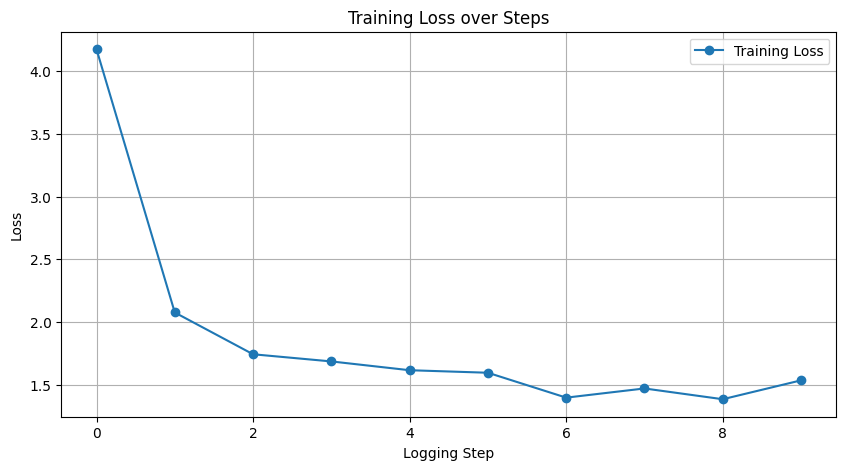

In [ ]:
import matplotlib.pyplot as plt

# Lấy loss từ lịch sử huấn luyện
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', marker='o')
plt.title('Training Loss over Steps')
plt.xlabel('Logging Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Validation Accuracy: 73.53%


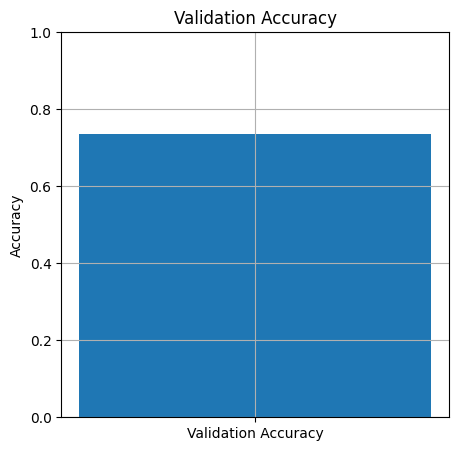

In [ ]:
def evaluate_model(model, dataset):
    model.eval()
    correct = 0
    total = 0

    for example in dataset:
        input_text = example['text']
        input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

        with torch.no_grad():
            output = model.generate(
                **input_ids,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=False,
            )

        response = tokenizer.decode(output[0][input_ids["input_ids"].shape[1]:], skip_special_tokens=True).lower()
        label = "positive" if example['label'] == 1 else "negative"

        if label in response:
            correct += 1
        total += 1

    return correct / total


accuracy = evaluate_model(model, val_dataset)
print(f"Validation Accuracy: {accuracy:.2%}")

# Biểu đồ accuracy
plt.figure(figsize=(5, 5))
plt.bar(['Validation Accuracy'], [accuracy])
plt.ylim(0, 1)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


## 8. Login and Save Model to HuggingFace

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `dailymail` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [ ]:
model.push_to_hub("thanhle1702/phii4-finetuned-sst2")
tokenizer.push_to_hub("thanhle1702/phii4-finetuned-sst2")

README.md:   0%|          | 0.00/584 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

Saved model to https://huggingface.co/thanhle1702/phii4-finetuned-sst2
